In [1]:
from functools import partial
from pathlib import Path
from typing import Optional, Tuple
import cv2
import fire
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
from matplotlib import pyplot as plt
import extract_utils as utils

## Extract Features

In [2]:
images_list="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/lists/images.txt"
# images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/VOC2012/images/trainval/JPEGImages"
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/images"
model_name="dino_vits16"
batch_size=1
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/feats_vis_feature_affinity"
which_block=-1
# Output
utils.make_output_dir(output_dir)
# Models
model_name = model_name.lower()
model, val_transform, patch_size, num_heads = utils.get_model(model_name)    #patch size= 16 number of heads= 6
print("patch size=", patch_size, "number of heads=", num_heads)

Using cache found in /home/phdcs2/.cache/torch/hub/facebookresearch_dino_main


patch size= 16 number of heads= 6


In [3]:
# Add hook
if 'dino' in model_name or 'mocov3' in model_name:
    feat_out = {}
    def hook_fn_forward_qkv(module, input, output):
        print("feat_out.keys()", feat_out.keys())
        feat_out["qkv"] = output
    model._modules["blocks"][which_block]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)
else:
    raise ValueError(model_name)

In [4]:
# Dataset
filenames = Path(images_list).read_text().splitlines()
dataset = utils.ImagesDataset(filenames=filenames, images_root=images_root, transform=val_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=8)
print(f'Dataset size: {len(dataset)=}')
print(f'Dataloader size: {len(dataloader)=}')

Dataset size: len(dataset)=1000
Dataloader size: len(dataloader)=1000


In [5]:
# Prepare
# accelerator = Accelerator(fp16=True, cpu=False)
accelerator = Accelerator(cpu=False)
# model, dataloader = accelerator.prepare(model, dataloader)
model = model.to(accelerator.device)
model.num_features
print("model.num_features=", model.num_features)

model.num_features= 384


In [6]:
model.get_submodule

<bound method Module.get_submodule of VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_

In [7]:
# Process
pbar = list(tqdm(dataloader, desc='Processing'))

Processing: 100%|██████████| 1000/1000 [00:09<00:00, 100.26it/s]


In [8]:
# Process
# pbar = list(tqdm(dataloader, desc='Processing'))
print("feat_out.keys()=", feat_out.keys())
for i, (images, files, indices) in enumerate(pbar[:2]):
    output_dict = {}
    print("images.shape=", images.shape, "files =", files, "indices", indices)

    # Check if file already exists
    id = Path(files[0]).stem
    print("id=", id)
    output_file = Path(output_dir) / f'{id}.pth'
    # if output_file.is_file():
    #     pbar.write(f'Skipping existing file {str(output_file)}')
    #     continue

    # Reshape image
    P = patch_size
    B, C, H, W = images.shape
    H_patch, W_patch = H // P, W // P
    H_pad, W_pad = H_patch * P, W_patch * P
    T = H_patch * W_patch + 1  # number of tokens, add 1 for [CLS]
    # images = F.interpolate(images, size=(H_pad, W_pad), mode='bilinear')  # resize image
    images = images[:, :, :H_pad, :W_pad]
    images = images.to(accelerator.device)
    print("images.shape after padding=", images.shape)

    # Forward and collect features into output dict
    if 'dino' in model_name or 'mocov3' in model_name:
        # accelerator.unwrap_model(model).get_intermediate_layers(images)[0].squeeze(0)
        model.get_intermediate_layers(images)[0].squeeze(0)
        print(model.get_intermediate_layers(images)[0])
        # output_dict['out'] = out
        print("feat_out.keys()=", feat_out.keys())
        output_qkv = feat_out["qkv"].reshape(B, T, 3, num_heads, -1 // num_heads).permute(2, 0, 3, 1, 4)
        print("type(output_qkv)", type(output_qkv))
        print("output_qkv.shape", output_qkv.shape)    #3, 1, 6, 931, 64]
        print("output_qkv[0].shape", output_qkv[0].shape)
        print("output_qkv[1].shape", output_qkv[1].shape)
        print("output_qkv[2].shape", output_qkv[2].shape)
        # output_dict['q'] = output_qkv[0].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
        output_dict['k'] = output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
        print("output_dict[k].shape=", output_dict['k'].shape)
        # output_dict['v'] = output_qkv[2].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
    else:
        raise ValueError(model_name)

    # print("output_dict.items=", output_dict.items())
    # Metadata
    output_dict['indices'] = indices[0]
    output_dict['file'] = files[0]
    output_dict['id'] = id
    output_dict['model_name'] = model_name
    output_dict['patch_size'] = patch_size
    output_dict['shape'] = (B, C, H, W)
    output_dict = {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in output_dict.items()}
    # for k, v in output_dict.items():
    #     print("k=", k)
    #     if torch.is_tensor(v):
    #         print("v.shape", v.shape)
    #     else:
    #         print("v=", v)
    print("output_dict.keys()", output_dict.keys())
    print("output_dict['k'].shape=", output_dict['k'].shape,"output_dict['indices'] =", indices[0],"output_dict['file'] =", files[0],"output_dict['id']=" , id, "output_dict['model_name'] =", model_name," output_dict['shape'] =(", B, C, H, W,")output_dict['patch_size'] =",  patch_size )
    # Save
    accelerator.save(output_dict, str(output_file))
    accelerator.wait_for_everyone()
print(f'Saved features to {output_dir}')

feat_out.keys()= dict_keys([])
images.shape= torch.Size([1, 3, 400, 267]) files = ('0001.jpg',) indices tensor([0])
id= 0001
images.shape after padding= torch.Size([1, 3, 400, 256])
feat_out.keys() dict_keys([])
feat_out.keys() dict_keys(['qkv'])
tensor([[[  4.1080,  -6.8098,   3.7193,  ..., -10.1830,   1.9089,  -0.3095],
         [  7.2783, -10.1525,  -1.5861,  ...,  -1.8359,   9.7533,  -1.3859],
         [  3.2214,  -5.3827,  -3.4998,  ...,  -0.5718,  -0.5539,  -1.7266],
         ...,
         [ -0.6573,  -0.4702,   2.3428,  ...,  -2.3507,  -1.5269,   0.6090],
         [ -2.1509,   3.9371,  -1.2622,  ...,   2.2995,   2.1495,  -0.1911],
         [ -2.2643,  -3.2050,  -3.8921,  ...,   3.7439,  -2.0177,  -3.8855]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
feat_out.keys()= dict_keys(['qkv'])
type(output_qkv) <class 'torch.Tensor'>
output_qkv.shape torch.Size([3, 1, 6, 401, 64])
output_qkv[0].shape torch.Size([1, 6, 401, 64])
output_qkv[1].shape torch.Size([1, 6, 401, 

In [9]:
# output_dict = {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in output_dict.items()}
# print(output_dict.keys())
# for k, v in output_dict.items():
#     print("k=", k)
#     print("v.shape=", v.shape)


## Extract Eigen Vectors

In [10]:
images_list="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/lists/images.txt"
# images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/VOC2012/images/trainval/JPEGImages"
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/images"
model_name="dino_vits16"
batch_size=1
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/feats_vis_feature_affinity"

In [11]:
images_list="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/lists/images.txt"
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/images"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/feats_vis_feature_affinity"
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/eigs_vis_feature_affinity"
which_matrix= 'laplacian'
which_color_matrix= 'knn'
which_features= 'k'
normalize=True
threshold_at_zero=True
lapnorm= True
K= 20
image_downsample_factor = None
image_color_lambda = 0.0
multiprocessing = 0

In [12]:
# def sigmoid(x):
#     return 1 / (1 + torch.exp(-x))
# def log(x):
#     return torch.log(x)

In [13]:
# def contrastive_affinity(matrix1, matrix2):
#     mat_mul=matrix1 @ matrix2
#     print("mat_mul device", mat_mul.device)
#
#     #Diagonal elements
#     if torch.cuda.is_available():
#         mask=torch.eye(mat_mul.shape[0], dtype=bool).cuda()
#     print("mask device", mask.device)
#     diag=mask
#     # print(diag)
#     diag_val=-log(sigmoid(mat_mul[diag]))
#     print("diag_val device", diag_val.device)
#     # print(diag_val)
#
#     # Off-Diagonal Elements
#     off_diag=~mask
#     # print(off_diag)
#     off_diag_val=-log(1-sigmoid(mat_mul[off_diag]))
#     # print(off_diag_val)
#     print("off-diag device",off_diag_val.device)
#
#     # Combining Diagonal and off-Diagonal element for contrastive affinities
#     if torch.cuda.is_available():
#         contra_affinity = torch.zeros(matrix1.shape[0],matrix2.shape[1]).cuda()
#     print("contra affinity device", contra_affinity.device)
#     # print(contra_affinity.shape)
#     torch.diagonal(contra_affinity).copy_(diag_val)
#     contra_affinity.masked_scatter_(~torch.eye(matrix1.shape[0], dtype=torch.bool).cuda(), off_diag_val)
#     return contra_affinity


In [14]:
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs[:2]):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    print("Without normalizing, Features Shape is",feats.shape)
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)
    print("After normalization, Features Shape",feats.shape)
    print("which_matrix=", which_matrix)
    # Eigenvectors of affinity matrix
    if which_matrix == 'affinity_torch':
        # W = feats @ feats.T
        W_feat=contrastive_affinity(feats, feats.T)
        print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
            print("W shape=", W.shape)
        eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
        eigenvalues = eigenvalues.cpu()
        eigenvectors = eigenvectors.cpu()
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity_svd':
        USV = torch.linalg.svd(feats, full_matrices=False)
        eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
        eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
        print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity':
        print("Without normalizing, Features Shape is",feats.shape)
        # W = (feats @ feats.T)
        W_feat=contrastive_affinity(feats, feats.T)
        print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
        W = W.cpu().numpy()
        print("W shape=", W.shape)
        eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
        eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of matting laplacian matrix
    elif which_matrix in ['matting_laplacian', 'laplacian']:

        # Get sizes
        B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
        if image_downsample_factor is None:
            image_downsample_factor = P
        H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

        # Upscale features to match the resolution
        if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
            feats = F.interpolate(
                feats.T.reshape(1, -1, H_patch, W_patch),
                size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
            ).reshape(-1, H_pad_lr * W_pad_lr).T

        ### Feature affinities
        print("Without normalizing, Features Shape is",feats.shape)
        W_feat = (feats @ feats.T)
        # W_feat=contrastive_affinity(feats, feats.T)
        if threshold_at_zero:
            W_feat = (W_feat * (W_feat > 0))
        W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
        W_feat = W_feat.cpu().numpy()
        print("W_feat shape=",W_feat.shape)

        ### Color affinities
        # If we are fusing with color affinites, then load the image and compute
        if image_color_lambda > 0:

            # Load image
            image_file = str(Path(images_root) / f'{image_id}.jpg')
            image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
            image_lr = np.array(image_lr) / 255.

            # Color affinities (of type scipy.sparse.csr_matrix)
            if which_color_matrix == 'knn':
                W_lr = utils.knn_affinity(image_lr / 255)
            elif which_color_matrix == 'rw':
                W_lr = utils.rw_affinity(image_lr / 255)

            # Convert to dense numpy array
            W_color = np.array(W_lr.todense().astype(np.float32))
            print("W_color shape", W_color.shape)

        else:

            # No color affinity
            W_color = 0

        # Combine
        W_comb = W_feat + W_color * image_color_lambda  # combination
        D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
        print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)

        # Extract eigenvectors
        if lapnorm:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
        else:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
        eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
    # Sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Save dictb
    output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    torch.save(output_dict, output_file)

  0%|          | 0/2 [00:00<?, ?it/s]

0 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/feats_vis_feature_affinity/0001.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
shape= (1, 3, 400, 267) k shape torch.Size([1, 400, 384]) patch_size= 16
0001
Without normalizing, Features Shape is torch.Size([400, 384])
After normalization, Features Shape torch.Size([400, 384])
which_matrix= laplacian
Without normalizing, Features Shape is torch.Size([400, 384])
W_feat shape= (400, 400)
W_comb shape=  (400, 400) D_comb shape (400, 400)


 50%|█████     | 1/2 [00:11<00:11, 11.36s/it]

eigenvalues shape torch.Size([20]) eigenvectors shape torch.Size([20, 400])
1 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/orig_images/feats_vis_feature_affinity/0002.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
shape= (1, 3, 400, 267) k shape torch.Size([1, 400, 384]) patch_size= 16
0002
Without normalizing, Features Shape is torch.Size([400, 384])
After normalization, Features Shape torch.Size([400, 384])
which_matrix= laplacian
Without normalizing, Features Shape is torch.Size([400, 384])
W_feat shape= (400, 400)
W_comb shape=  (400, 400) D_comb shape (400, 400)


100%|██████████| 2/2 [00:19<00:00,  9.89s/it]

eigenvalues shape torch.Size([20]) eigenvectors shape torch.Size([20, 400])


In [15]:
eigenvectors.shape

torch.Size([20, 400])

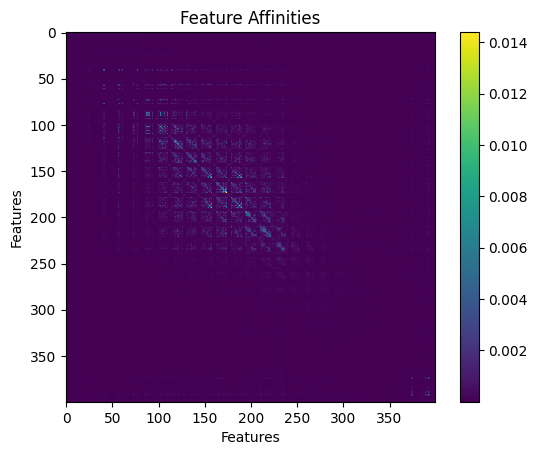

In [19]:
eigenvectors=eigenvectors.cpu()
correlation_matrix = torch.abs(torch.mm(eigenvectors.t(), eigenvectors))
plt.imshow(correlation_matrix, cmap=plt.cm.viridis, interpolation='nearest')
plt.colorbar()
plt.title('Feature Affinities')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()